In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import tf_keras

2025-08-18 09:23:31.566176: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-18 09:23:31.580593: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/kdrabicki/anaconda3/envs/cpu_env/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


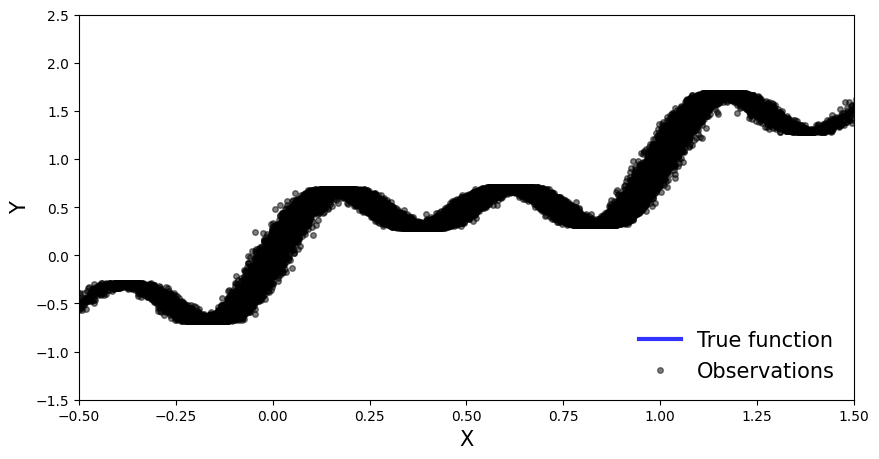

In [221]:
np.random.seed(42+1)

X_train = np.hstack([0.2 * np.random.randn(10000), 0.5 + 0.2 * np.random.randn(10000), 1 + 0.2 * np.random.randn(10000)])
noise = 0.02 * np.random.randn(X_train.shape[0])
y_train = X_train + 0.3 * np.sin(2 * np.pi * (X_train + noise)) + 0.3 * np.sin(4 * np.pi * (X_train + noise)) + noise

x_true = np.linspace(-0.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_true, y_true, 'b-', linewidth=3, label="True function", alpha=0.8)
ax.plot(X_train, y_train, 'ko', markersize=4, label="Observations", alpha=0.5)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("X", fontsize=15)
ax.set_ylabel("Y", fontsize=15)
ax.legend(loc=4, fontsize=15, frameon=False)

plt.show()

In [49]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf_keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf_keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [229]:
model = tf_keras.Sequential([
    tf_keras.layers.Dense(128, activation='relu', input_shape=(1,)),
    tf_keras.layers.Dense(128, activation='relu'),
    tf_keras.layers.Dense(128, activation='relu'),
    tf_keras.layers.Dense(1),
])


model.compile(optimizer=tf_keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 128)               256       
                                                                 
 dense_71 (Dense)            (None, 128)               16512     
                                                                 
 dense_72 (Dense)            (None, 128)               16512     
                                                                 
 dense_73 (Dense)            (None, 1)                 129       
                                                                 
Total params: 33409 (130.50 KB)
Trainable params: 33409 (130.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [230]:
history = model.fit(X_train,y_train, epochs=100, verbose=1)

Epoch 1/100
938/938 [==============================] - 0s 258us/step - loss: 0.0491
Epoch 2/100
938/938 [==============================] - 0s 251us/step - loss: 0.0149
Epoch 3/100
938/938 [==============================] - 0s 246us/step - loss: 0.0073
Epoch 4/100
938/938 [==============================] - 0s 248us/step - loss: 0.0067
Epoch 5/100
938/938 [==============================] - 0s 256us/step - loss: 0.0064
Epoch 6/100
938/938 [==============================] - 0s 251us/step - loss: 0.0064
Epoch 7/100
938/938 [==============================] - 0s 250us/step - loss: 0.0064
Epoch 8/100
938/938 [==============================] - 0s 244us/step - loss: 0.0063
Epoch 9/100
938/938 [==============================] - 0s 252us/step - loss: 0.0060
Epoch 10/100
938/938 [==============================] - 0s 256us/step - loss: 0.0059
Epoch 11/100
938/938 [==============================] - 0s 251us/step - loss: 0.0058
Epoch 12/100
938/938 [==============================] - 0s 254us/step - lo

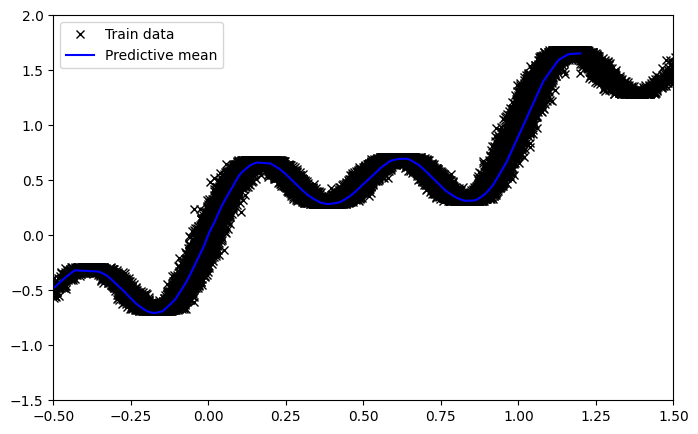

In [231]:
x_test = np.linspace(-0.5, 1.2, 200).reshape(-1,1).astype(np.float32)
y_pred = model(x_test)  # returns a tfd.Distribution
# y_mean = y_pred_dist.mean().numpy()
# y_std = y_pred_dist.stddev().numpy()

# ---- Simple visualization ----
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(X_train, y_train, 'kx', label='Train data')
plt.plot(x_test, y_pred, 'b', label='Predictive mean')
# plt.fill_between(x_test.flatten(),
#                  (y_mean - 2*y_std).reshape(-1),
#                  (y_mean + 2*y_std).reshape(-1),
#                  color='blue', alpha=0.2, label='Predictive ±2σ')
plt.ylim(-1.5,2)
plt.xlim(-0.5, 1.5)
plt.legend()
plt.show()

In [258]:
tfd = tfp.distributions
tfpl = tfp.layers

event_shape = [1]
params_size = tfp.layers.MixtureNormal.params_size(1, event_shape)

norm_layer = tf_keras.layers.Normalization(input_shape=(1,))
norm_layer.adapt(X_train.reshape(-1,1))

model = tf_keras.Sequential([
    norm_layer,
    tf_keras.layers.Dense(256, activation='relu'),
    tf_keras.layers.BatchNormalization(),
    tf_keras.layers.Dense(256, activation='relu'),
    tf_keras.layers.BatchNormalization(),
    tf_keras.layers.Dense(256, activation='relu'),
    tf_keras.layers.BatchNormalization(),
    tf_keras.layers.Dense(256, activation='relu'),
    tf_keras.layers.BatchNormalization(),
    tfpl.DenseFlipout(64, activation='relu'),
    tf_keras.layers.BatchNormalization(),
    tf_keras.layers.Dense(params_size),
    tfp.layers.MixtureNormal(1, event_shape)
])

def negloglik(y_true, y_pred):
    return -y_pred.log_prob(y_true)

lr_schedule = tf_keras.optimizers.schedules.ExponentialDecay(0.001, 16*1000, 0.99,staircase=False)

model.compile(optimizer=tf_keras.optimizers.Adam(learning_rate=0.0001), loss=negloglik)
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_25 (Normaliz  (None, 1)                 3         
 ation)                                                          
                                                                 
 dense_99 (Dense)            (None, 256)               512       
                                                                 
 batch_normalization_96 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dense_100 (Dense)           (None, 256)               65792     
                                                                 
 batch_normalization_97 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                     

In [259]:
x_test = np.linspace(-0.5, 1.5, 1000)
y_test = x_test + 0.3 * np.sin(2 * np.pi * x_test) + 0.3 * np.sin(4 * np.pi * x_test)


loss_log_dir = "../logs/fit/loss/BNN"
history = model.fit(X_train,y_train, validation_data=(x_test, y_test), epochs=1000, verbose=1, batch_size=256,
                    callbacks=[tf_keras.callbacks.TensorBoard(log_dir=loss_log_dir, histogram_freq=1), tf_keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                                                                                        mode='min',
                                                                                                                                        patience=30,
                                                                                                                                        verbose=1,
                                                                                                                                        start_from_epoch=1,
                                                                                                                                        restore_best_weights=True)])

Epoch 1/1000
118/118 [==============================] - 1s 5ms/step - loss: 41362.1914 - val_loss: 41262.7852
Epoch 2/1000
118/118 [==============================] - 0s 3ms/step - loss: 41167.4375 - val_loss: 41068.9844
Epoch 3/1000
118/118 [==============================] - 0s 3ms/step - loss: 40973.0078 - val_loss: 40874.5117
Epoch 4/1000
118/118 [==============================] - 0s 3ms/step - loss: 40778.7812 - val_loss: 40680.9844
Epoch 5/1000
118/118 [==============================] - 0s 3ms/step - loss: 40584.7969 - val_loss: 40487.4141
Epoch 6/1000
118/118 [==============================] - 0s 3ms/step - loss: 40391.2305 - val_loss: 40293.6328
Epoch 7/1000
118/118 [==============================] - 0s 3ms/step - loss: 40198.1406 - val_loss: 40100.4688
Epoch 8/1000
118/118 [==============================] - 0s 3ms/step - loss: 40005.5430 - val_loss: 39908.1484
Epoch 9/1000
118/118 [==============================] - 0s 3ms/step - loss: 39813.4492 - val_loss: 39716.3359
Epoch 10/1

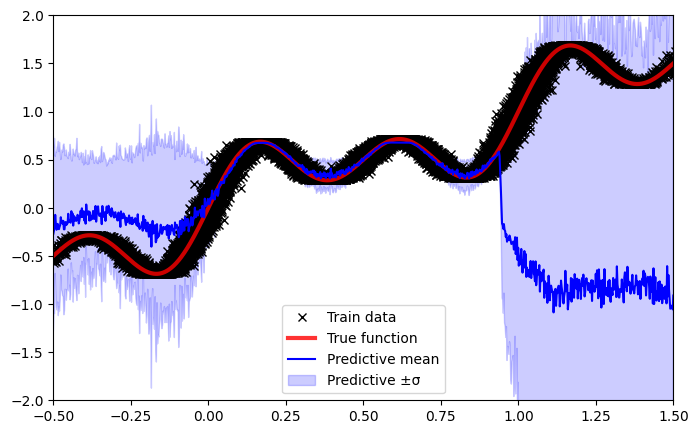

In [260]:
means = []
stds = []
for _ in range(10):
    dist = model(x_test)
    means.append(dist.mean().numpy())
    stds.append(dist.stddev().numpy())

y_mean = np.array(means).mean(axis=0)
y_std = np.sqrt(np.sum(np.array(stds) ** 2 / 10, axis=0))
y_mean_std = np.array(means).std(axis=0)
y_std = np.sqrt(y_std ** 2 + y_mean_std ** 2)


import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(X_train, y_train, 'kx', label='Train data')
plt.plot(x_true, y_true, 'r', linewidth=3, label="True function", alpha=0.8)
plt.plot(x_test, y_mean, color='b', label='Predictive mean')
plt.fill_between(x_test.flatten(),
                 (y_mean - y_std).reshape(-1),
                 (y_mean + y_std).reshape(-1),
                 color='blue', alpha=0.2, label='Predictive ±σ')
plt.ylim(-2,2)
plt.xlim(-0.5, 1.5)
plt.legend()
plt.show()

(array([   5.,   20.,   38.,  126.,  293.,  501.,  895., 1272., 1552.,
        1701., 1671., 1580., 1476., 1509., 1733., 1753., 1583., 1514.,
        1536., 1486., 1574., 1669., 1579., 1217.,  834.,  486.,  251.,
         107.,   30.,    9.]),
 array([-0.73570876, -0.65548039, -0.57525202, -0.49502366, -0.41479529,
        -0.33456692, -0.25433855, -0.17411018, -0.09388181, -0.01365344,
         0.06657492,  0.14680329,  0.22703166,  0.30726003,  0.3874884 ,
         0.46771677,  0.54794514,  0.62817351,  0.70840187,  0.78863024,
         0.86885861,  0.94908698,  1.02931535,  1.10954372,  1.18977209,
         1.27000046,  1.35022882,  1.43045719,  1.51068556,  1.59091393,
         1.6711423 ]),
 [<matplotlib.patches.Polygon at 0x7a585d72ae70>])

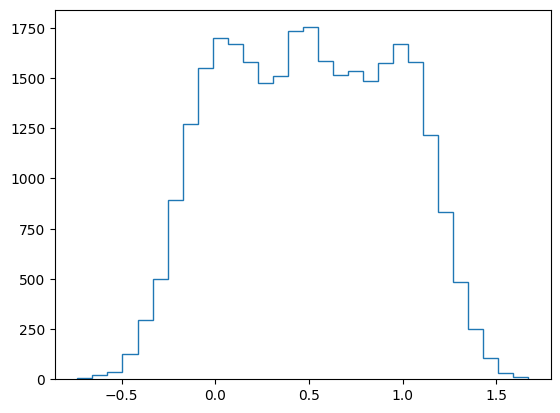

In [263]:
plt.hist(X_train, bins=30, histtype="step")